# Make one validation set and see the patern between models to ensemble

In [1]:
# Load Libraries
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

In [2]:
# Models
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

/home/titanuser/anaconda3/envs/cpu/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [5]:
# function to clean data

stops = set(stopwords.words("english"))
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt

In [6]:
## join data
test['Is_Response'] = np.nan
alldata = pd.concat([train, test]).reset_index(drop=True)

In [7]:
# clean description
alldata['Description'] = alldata['Description'].map(lambda x: cleanData(x, lowercase=True, remove_stops=False, stemming=True))

In [8]:
alldata.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,the room wa kind of clean but had a veri stron...,Edge,Mobile,not happy
1,id10327,i stay at the crown plaza april april the staf...,Internet Explorer,Mobile,not happy
2,id10328,i book thi hotel through hotwir at the lowest ...,Mozilla,Tablet,not happy
3,id10329,stay here with husband and son on the way to a...,InternetExplorer,Desktop,happy
4,id10330,my girlfriend and i stay here to celebr our th...,Edge,Tablet,not happy


In [9]:
alldata['Description'][1]

'i stay at the crown plaza april april the staff wa friendli and attent the elev are tini about by the food in the restaur wa delici but price a littl on the high side of cours thi is washington dc there is no pool and littl for children to do my room on the fifth floor had two comfort bed and plenti of space for one person the tv is a littl small by today standard with a limit number of channel there wa a small bit of mold in the bathtub area that could have been remov with a littl bleach it appear the carpet were not vacum everi day i report a light bulb wa burn out it wa never replac ice machin are on the odd number floor but the one on my floor did not work i encount some staff in the elev one even and i mention the ice machin to them severel hour later a maid appear at my door with ice and two mint im not sure how they knew what room i wa in that wa a littl unnerv i would stay here again for busi but would not come here on vacat'

In [10]:
alldata.Is_Response.value_counts()

happy        26521
not happy    12411
Name: Is_Response, dtype: int64

In [11]:
# initialise the functions - we'll create separate models for each type.
countvec = CountVectorizer(analyzer='word', ngram_range = (1,1), min_df = 0, max_features=1600)
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,1), min_df = 0, max_features=1600)

# create features
bagofwords = countvec.fit_transform(alldata['Description'])
tfidfdata = tfidfvec.fit_transform(alldata['Description'])

In [12]:
# label encode categorical features in data given
cols = ['Browser_Used','Device_Used']

for x in cols:
    lbl = LabelEncoder()
    alldata[x] = lbl.fit_transform(alldata[x])

In [13]:
# create dataframe for features
bow_df = pd.DataFrame(bagofwords.todense())
tfidf_df = pd.DataFrame(tfidfdata.todense())

In [14]:
# set column names
bow_df.columns = ['col'+ str(x) for x in bow_df.columns]
tfidf_df.columns = ['col' + str(x) for x in tfidf_df.columns]


In [15]:
# create separate data frame for bag of words and tf-idf

bow_df_train = bow_df[:len(train)]
bow_df_test = bow_df[len(train):]

tfid_df_train = tfidf_df[:len(train)]
tfid_df_test = tfidf_df[len(train):]

In [16]:
# split the merged data file into train and test respectively
train_feats = alldata[~pd.isnull(alldata.Is_Response)]
test_feats = alldata[pd.isnull(alldata.Is_Response)]


In [17]:
train_feats['Is_Response'] = [1 if x == 'happy' else 0 for x in train_feats['Is_Response']]

/home/titanuser/anaconda3/envs/cpu/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
# merge count (bag of word) features into train
train_feats1 = pd.concat([train_feats[cols], bow_df_train], axis = 1)
test_feats1 = pd.concat([test_feats[cols], bow_df_test], axis=1)
test_feats1.reset_index(drop=True, inplace=True)

In [19]:
# merge into a new data frame with tf-idf features
train_feats2 = pd.concat([train_feats[cols], tfid_df_train], axis=1)
test_feats2 = pd.concat([test_feats[cols], tfid_df_test], axis=1)
target = train_feats['Is_Response']

In [21]:
## Naive Bayes 1
#[ 0.79185927  0.77819163  0.79026458  0.78564089  0.78769586] > (1,2)
model1 = GaussianNB()
print(cross_val_score(model1, train_feats1, target, cv=5, scoring=make_scorer(accuracy_score)))

model1.fit(train_feats1, target)

pred1 = model1.predict(test_feats1)

[ 0.79417052  0.78769586  0.78949396  0.78975083  0.79668636]


In [22]:
## Naive Bayes 2 - tfidf is giving higher CV score
#[ 0.82550077  0.82712561  0.83162086  0.83367583  0.82430003] > (1,2)
model2 = GaussianNB()
print(cross_val_score(model2, train_feats2, target, cv=5, scoring=make_scorer(accuracy_score)))

model2.fit(train_feats2, target)

pred2 = model2.predict(test_feats2)

[ 0.81779661  0.81697919  0.8061906   0.82031852  0.81453892]


In [24]:
# set the data in format lgb accepts
d_train1 = lgb.Dataset(train_feats1, label = target)

params1 = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_error', 
           'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 60, 'feature_fraction': 0.8, 
           'bagging_fraction': 0.8, 'bagging_freq': 5}

lgb_cv1 = lgb.cv(params1, d_train1, num_boost_round=5000, nfold= 5, shuffle=True, stratified=True, verbose_eval=20)

[20]	cv_agg's binary_error: 0.178259 + 0.00336278
[40]	cv_agg's binary_error: 0.163773 + 0.0047215
[60]	cv_agg's binary_error: 0.153164 + 0.00487745
[80]	cv_agg's binary_error: 0.144688 + 0.0045537
[100]	cv_agg's binary_error: 0.138318 + 0.00429984
[120]	cv_agg's binary_error: 0.133771 + 0.00504577
[140]	cv_agg's binary_error: 0.130715 + 0.00450431
[160]	cv_agg's binary_error: 0.127633 + 0.00457276
[180]	cv_agg's binary_error: 0.125372 + 0.00438364
[200]	cv_agg's binary_error: 0.122701 + 0.00448379
[220]	cv_agg's binary_error: 0.121134 + 0.0047124
[240]	cv_agg's binary_error: 0.118899 + 0.00432235
[260]	cv_agg's binary_error: 0.117127 + 0.00488055
[280]	cv_agg's binary_error: 0.115637 + 0.00421206
[300]	cv_agg's binary_error: 0.114327 + 0.00440248
[320]	cv_agg's binary_error: 0.113762 + 0.00390037
[340]	cv_agg's binary_error: 0.112709 + 0.00414435
[360]	cv_agg's binary_error: 0.112504 + 0.003363
[380]	cv_agg's binary_error: 0.111707 + 0.00330244
[400]	cv_agg's binary_error: 0.111579 + 

[3220]	cv_agg's binary_error: 0.104541 + 0.00284227
[3240]	cv_agg's binary_error: 0.104541 + 0.00265901
[3260]	cv_agg's binary_error: 0.104336 + 0.00265941
[3280]	cv_agg's binary_error: 0.104259 + 0.00220302
[3300]	cv_agg's binary_error: 0.10431 + 0.00215864
[3320]	cv_agg's binary_error: 0.104079 + 0.00236877
[3340]	cv_agg's binary_error: 0.104156 + 0.00262008
[3360]	cv_agg's binary_error: 0.10431 + 0.00210323
[3380]	cv_agg's binary_error: 0.104336 + 0.00213718
[3400]	cv_agg's binary_error: 0.10449 + 0.00263374
[3420]	cv_agg's binary_error: 0.104464 + 0.00237799
[3440]	cv_agg's binary_error: 0.104387 + 0.00246398
[3460]	cv_agg's binary_error: 0.10413 + 0.00250666
[3480]	cv_agg's binary_error: 0.104387 + 0.00268169
[3500]	cv_agg's binary_error: 0.10449 + 0.00247297
[3520]	cv_agg's binary_error: 0.10431 + 0.00213703
[3540]	cv_agg's binary_error: 0.104438 + 0.00240004
[3560]	cv_agg's binary_error: 0.104284 + 0.00215248
[3580]	cv_agg's binary_error: 0.104027 + 0.00234239
[3600]	cv_agg's bi

In [25]:
## get nround value which hd lowest error
nround = lgb_cv1['binary_error-mean'].index(np.min(lgb_cv1['binary_error-mean']))

## train the model
model3 = lgb.train(params1, d_train1, num_boost_round=nround)

## make predictions
pred3 = model3.predict(test_feats1)

In [26]:
d_train2 = lgb.Dataset(train_feats2, label = target)

params2 = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_error', 
           'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 71, 'feature_fraction': 0.8, 
           'bagging_fraction': 0.8, 'bagging_freq': 5}

lgb_cv2 = lgb.cv(params2, d_train2, num_boost_round=4000, nfold= 5, shuffle=True, stratified=True, verbose_eval=20)

[20]	cv_agg's binary_error: 0.176667 + 0.00363473
[40]	cv_agg's binary_error: 0.161487 + 0.00316434
[60]	cv_agg's binary_error: 0.153139 + 0.00359468
[80]	cv_agg's binary_error: 0.145253 + 0.00376399
[100]	cv_agg's binary_error: 0.138832 + 0.00360289
[120]	cv_agg's binary_error: 0.13467 + 0.0043109
[140]	cv_agg's binary_error: 0.131306 + 0.00433657
[160]	cv_agg's binary_error: 0.128377 + 0.00433327
[180]	cv_agg's binary_error: 0.126143 + 0.00360031
[200]	cv_agg's binary_error: 0.123934 + 0.00299198
[220]	cv_agg's binary_error: 0.12247 + 0.00297129
[240]	cv_agg's binary_error: 0.121571 + 0.00338671
[260]	cv_agg's binary_error: 0.120004 + 0.00341535
[280]	cv_agg's binary_error: 0.119233 + 0.00352448
[300]	cv_agg's binary_error: 0.118411 + 0.00346366
[320]	cv_agg's binary_error: 0.117692 + 0.00322209
[340]	cv_agg's binary_error: 0.117153 + 0.00324736
[360]	cv_agg's binary_error: 0.116382 + 0.00346871
[380]	cv_agg's binary_error: 0.115483 + 0.00299502
[400]	cv_agg's binary_error: 0.115175 

[3220]	cv_agg's binary_error: 0.108163 + 0.00360761
[3240]	cv_agg's binary_error: 0.108368 + 0.00360041
[3260]	cv_agg's binary_error: 0.108291 + 0.00386695
[3280]	cv_agg's binary_error: 0.107778 + 0.00383876
[3300]	cv_agg's binary_error: 0.107958 + 0.00391998
[3320]	cv_agg's binary_error: 0.107726 + 0.00417689
[3340]	cv_agg's binary_error: 0.108086 + 0.00411535
[3360]	cv_agg's binary_error: 0.107906 + 0.0038232
[3380]	cv_agg's binary_error: 0.107906 + 0.00353776
[3400]	cv_agg's binary_error: 0.10806 + 0.0039962
[3420]	cv_agg's binary_error: 0.107829 + 0.00382584
[3440]	cv_agg's binary_error: 0.107752 + 0.00382041
[3460]	cv_agg's binary_error: 0.107572 + 0.00346167
[3480]	cv_agg's binary_error: 0.108034 + 0.00351187
[3500]	cv_agg's binary_error: 0.107803 + 0.00337608
[3520]	cv_agg's binary_error: 0.107983 + 0.00362012
[3540]	cv_agg's binary_error: 0.10788 + 0.00387972
[3560]	cv_agg's binary_error: 0.107726 + 0.00383978
[3580]	cv_agg's binary_error: 0.107649 + 0.00355442
[3600]	cv_agg's 

In [27]:
## get nround value which hd lowest error
nround = lgb_cv2['binary_error-mean'].index(np.min(lgb_cv2['binary_error-mean']))

## train the model
model4 = lgb.train(params2, d_train2, num_boost_round=nround)

## make predictions
pred4 = model4.predict(test_feats2)

In [29]:
#[ 0.88726246  0.89288466  0.90033393  0.89545338  0.89211405]
model5 = XGBClassifier(learning_rate =0.07,
                     n_estimators=600,
                     max_depth=9,
                     min_child_weight=6,
                     gamma=0.1,
                     reg_alpha=0.01,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     scale_pos_weight=1,
                     seed=27)
print(cross_val_score(model5, train_feats1, target, cv=5, scoring=make_scorer(accuracy_score)))

model5.fit(train_feats1, target)

pred5 = model5.predict(test_feats1)

[ 0.88726246  0.89288466  0.90033393  0.89545338  0.89211405]


In [30]:
#[ 0.88585003  0.89108657  0.89108657  0.89378371  0.88710506]

model6 = XGBClassifier(learning_rate =0.1,
                     n_estimators=600,
                     max_depth=9,
                     min_child_weight=6,
                     gamma=0.1,
                     reg_alpha=0.01,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     scale_pos_weight=1,
                     seed=27)
print(cross_val_score(model6, train_feats2, target, cv=5, scoring=make_scorer(accuracy_score)))

model6.fit(train_feats2, target)

pred6 = model6.predict(test_feats2)

[ 0.88585003  0.89108657  0.89108657  0.89378371  0.88710506]


In [31]:
#[ 0.87262455  0.87760082  0.88106858  0.86103262  0.86424351]

model7 = LogisticRegression(penalty='l2', dual=True, tol=0.0001, 
                         C=2.8, fit_intercept=True, intercept_scaling=1.0, 
                         class_weight=None, random_state=None)

print(cross_val_score(model7, train_feats1, target, cv=5, scoring=make_scorer(accuracy_score)))
model7.fit(train_feats1, target)
pred7 = model7.predict(test_feats1)

[ 0.87262455  0.87760082  0.88106858  0.86103262  0.86424351]


In [32]:
#[ 0.88263996  0.8858207   0.89031595  0.88607758  0.88376573]

model8 = LogisticRegression(penalty='l2', dual=True, tol=0.0001, 
                         C=2.8, fit_intercept=True, intercept_scaling=1.0, 
                         class_weight=None, random_state=None)

print(cross_val_score(model8, train_feats2, target, cv=5, scoring=make_scorer(accuracy_score)))
model8.fit(train_feats2, target)
pred8 = model8.predict(test_feats2)

[ 0.88263996  0.8858207   0.89031595  0.88607758  0.88376573]


In [33]:
model9 = MLPClassifier(hidden_layer_sizes=(90,60,40,20))
print(cross_val_score(model9, train_feats1, target, cv=5, scoring=make_scorer(accuracy_score)))
model9.fit(train_feats1, target)
pred9 = model9.predict(test_feats1)

[ 0.85862866  0.86206011  0.865271    0.85974827  0.86103262]


In [34]:
model10 = MLPClassifier(hidden_layer_sizes=(90,60,40,20))
print(cross_val_score(model10, train_feats2, target, cv=5, scoring=make_scorer(accuracy_score)))
model10.fit(train_feats2, target)
pred10 = model10.predict(test_feats2)

[ 0.85952748  0.86154637  0.8670691   0.86360134  0.8710506 ]


In [60]:
def to_labels(x):
    if x > 0.48:
        return 1
    return 0

In [90]:
predtrain1 = model1.predict(train_feats1)
predtrain2 = model2.predict(train_feats2)

predtrain3 = model3.predict(train_feats1)
predtrain3 = pd.DataFrame(predtrain3)
predtrain3[0] = predtrain3[0].map(lambda x: to_labels(x))

predtrain4 = model4.predict(train_feats2)
predtrain4 = pd.DataFrame(predtrain4)
predtrain4[0] = predtrain4[0].map(lambda x: to_labels(x))

predtrain5 = model5.predict(train_feats1)
predtrain6 = model6.predict(train_feats2)
predtrain7 = model7.predict(train_feats1)
predtrain8 = model8.predict(train_feats2)
predtrain9 = model9.predict(train_feats1)
predtrain10 = model10.predict(train_feats2)

In [104]:
predtrain1 = pd.DataFrame(predtrain1)
predtrain2 = pd.DataFrame(predtrain2)
predtrain3 = pd.DataFrame(predtrain3)
predtrain4 = pd.DataFrame(predtrain4)
predtrain5 = pd.DataFrame(predtrain5)
predtrain6 = pd.DataFrame(predtrain6)
predtrain7 = pd.DataFrame(predtrain7)
predtrain8 = pd.DataFrame(predtrain8)
predtrain9 = pd.DataFrame(predtrain9)
predtrain10 = pd.DataFrame(predtrain10)

predictions = pd.concat([predtrain1, predtrain2, predtrain3, predtrain4, predtrain5, predtrain6, predtrain7, predtrain8, predtrain9, predtrain10, target], axis=1)
X_train = pd.concat([train_feats1, predtrain1[0], predtrain2[0], predtrain3, predtrain4, predtrain5[0], predtrain6[0], predtrain7[0], predtrain8[0], predtrain9[0], predtrain10[0]], axis=1)
print(X_train.shape)
print(predictions.shape)

(38932, 1612)
(38932, 11)


In [105]:
# set the data in format lgb accepts
predictions['sum'] = predtrain1 + predtrain2 + predtrain3 + predtrain4 + predtrain5 + predtrain6 + predtrain7 + predtrain8 + predtrain9 + predtrain10

In [110]:
predictions.columns = ['naive1','naive2','lightgbm1','lightgbm2','xgb1','xgb2','logistic1','logistic2','nn1','nn2','Is_Response','sum']

In [123]:
predictions[predictions['logistic1'] != predictions.Is_Response].shape

(4017, 12)

In [112]:
predictions.to_csv('predictions.csv', index=False)

In [60]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(train_feats1)
X_train = std_scale.transform(train_feats1)

# on non-standardized data
pca = PCA(n_components=3).fit(X_train)
X_train = pca.transform(X_train)


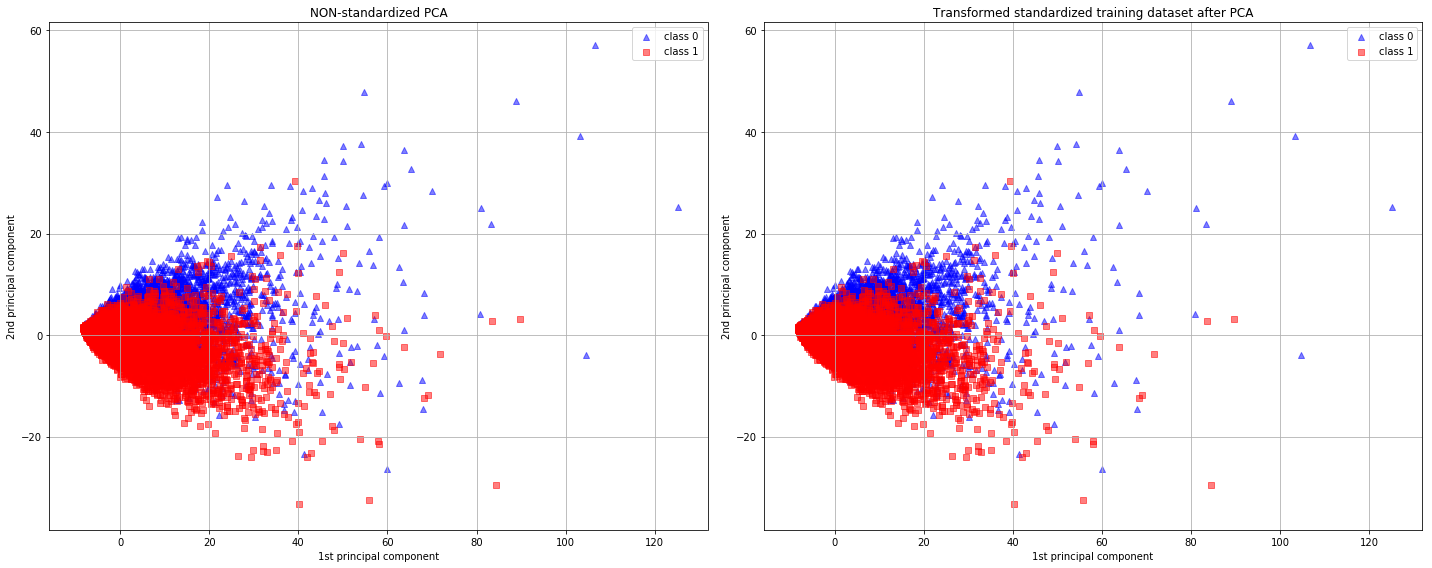

In [61]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))


for l,c,m in zip(range(0,2), ('blue', 'red'), ('^', 's')):
    ax1.scatter(X_train[target==l, 0], X_train[target==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

for l,c,m in zip(range(0,2), ('blue', 'red'), ('^', 's')):
    ax2.scatter(X_train[target==l, 0], X_train[target==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

ax1.set_title('NON-standardized PCA')    
ax2.set_title('Transformed standardized training dataset after PCA')    

for ax in (ax1, ax2):

    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()
plt.tight_layout()

plt.show()

/home/titanuser/anaconda3/envs/cpu/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


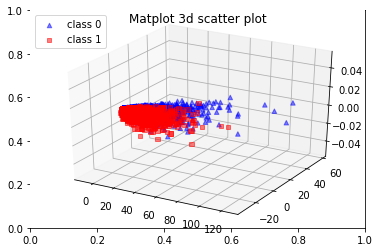

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
 

data = X_train
colors = ("red", "green", "blue")
groups = ("coffee", "tea", "water") 
 
# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
 
for l,c,m in zip(range(0,2), ('blue', 'red'), ('^', 's')):
    ax.scatter(X_train[target==l, 0], X_train[target==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

plt.title('Matplot 3d scatter plot')
plt.legend(loc=2)
plt.show()

In [63]:
X_train

array([[-5.93004149,  0.99740542, -1.89234542],
       [ 3.20252792,  0.25158537, -3.5047709 ],
       [ 3.53481969, -1.1483062 , -3.6046322 ],
       ..., 
       [ 4.38940602,  9.49884469,  3.05081073],
       [-3.30482179,  1.36770913, -0.97459388],
       [-7.67995692,  1.00852684, -0.50200129]])

In [64]:
from sklearn import svm
svmclf = svm.SVC()
#classifier_linear = svm.SVC(kernel='linear')
#classifier_liblinear = svm.LinearSVC()
svmclf.fit(X_train, target)
#print(cross_val_score(svmclf, X_train, target, cv=5, scoring=make_scorer(accuracy_score)))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
print(svmclf.score(X_train, target))

0.850534264872


In [71]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label = target)
## set parameters
## you can tune the parameters can try to better score

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'num_leaves': 10, 
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}

lgb_cv = lgb.cv(params,
                d_train,
                num_boost_round=4000,
                nfold= 5,
                shuffle=True, 
                stratified=True,
                verbose_eval=20, 
                )

[20]	cv_agg's binary_error: 0.179955 + 0.00156439
[40]	cv_agg's binary_error: 0.17117 + 0.00156401
[60]	cv_agg's binary_error: 0.163773 + 0.00335679
[80]	cv_agg's binary_error: 0.161589 + 0.00259945
[100]	cv_agg's binary_error: 0.159792 + 0.00250734
[120]	cv_agg's binary_error: 0.159714 + 0.00202912
[140]	cv_agg's binary_error: 0.158867 + 0.00223087
[160]	cv_agg's binary_error: 0.158199 + 0.00196744
[180]	cv_agg's binary_error: 0.158276 + 0.00253253
[200]	cv_agg's binary_error: 0.15843 + 0.00237801
[220]	cv_agg's binary_error: 0.158661 + 0.00246161
[240]	cv_agg's binary_error: 0.158584 + 0.00243876
[260]	cv_agg's binary_error: 0.158687 + 0.00264982
[280]	cv_agg's binary_error: 0.158096 + 0.00224034
[300]	cv_agg's binary_error: 0.158687 + 0.00217841
[320]	cv_agg's binary_error: 0.158892 + 0.00260886
[340]	cv_agg's binary_error: 0.158456 + 0.00294198
[360]	cv_agg's binary_error: 0.15843 + 0.00278066
[380]	cv_agg's binary_error: 0.158225 + 0.00247863
[400]	cv_agg's binary_error: 0.158404 

[3220]	cv_agg's binary_error: 0.164415 + 0.00331559
[3240]	cv_agg's binary_error: 0.164441 + 0.00315578
[3260]	cv_agg's binary_error: 0.164569 + 0.00316343
[3280]	cv_agg's binary_error: 0.164389 + 0.00311681
[3300]	cv_agg's binary_error: 0.164672 + 0.00308791
[3320]	cv_agg's binary_error: 0.164466 + 0.00319606
[3340]	cv_agg's binary_error: 0.164235 + 0.00303498
[3360]	cv_agg's binary_error: 0.164261 + 0.00295347
[3380]	cv_agg's binary_error: 0.164209 + 0.00276477
[3400]	cv_agg's binary_error: 0.164364 + 0.00308175
[3420]	cv_agg's binary_error: 0.164492 + 0.00288262
[3440]	cv_agg's binary_error: 0.164286 + 0.00289191
[3460]	cv_agg's binary_error: 0.164107 + 0.00285695
[3480]	cv_agg's binary_error: 0.164184 + 0.0027387
[3500]	cv_agg's binary_error: 0.164055 + 0.00280064
[3520]	cv_agg's binary_error: 0.164235 + 0.00284112
[3540]	cv_agg's binary_error: 0.164466 + 0.00288851
[3560]	cv_agg's binary_error: 0.164286 + 0.00288168
[3580]	cv_agg's binary_error: 0.164466 + 0.00304422
[3600]	cv_agg

In [32]:
from time import time

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

from sklearn import manifold

from sklearn.decomposition import PCA
from sklearn import preprocessing

t0 = time()
std_scale = preprocessing.StandardScaler().fit(train_feats1)
X_train = std_scale.transform(train_feats1)
t1 = time()
print("Scale: %.2g sec" % (t1 - t0))
# on non-standardized data
t0 = time()
pca = PCA(n_components=3).fit(X_train)
X_train = pca.transform(X_train)
t1 = time()
print("PCA: %.2g sec" % (t1 - t0))

t0 = time()
tsne = manifold.Isomap(10, 2).fit_transform(X_train)
X_train = tsne.fit_transform(X_train)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))


Scale: 1.1 sec
PCA: 5.8 sec


AttributeError: 'numpy.ndarray' object has no attribute 'fit_transform'

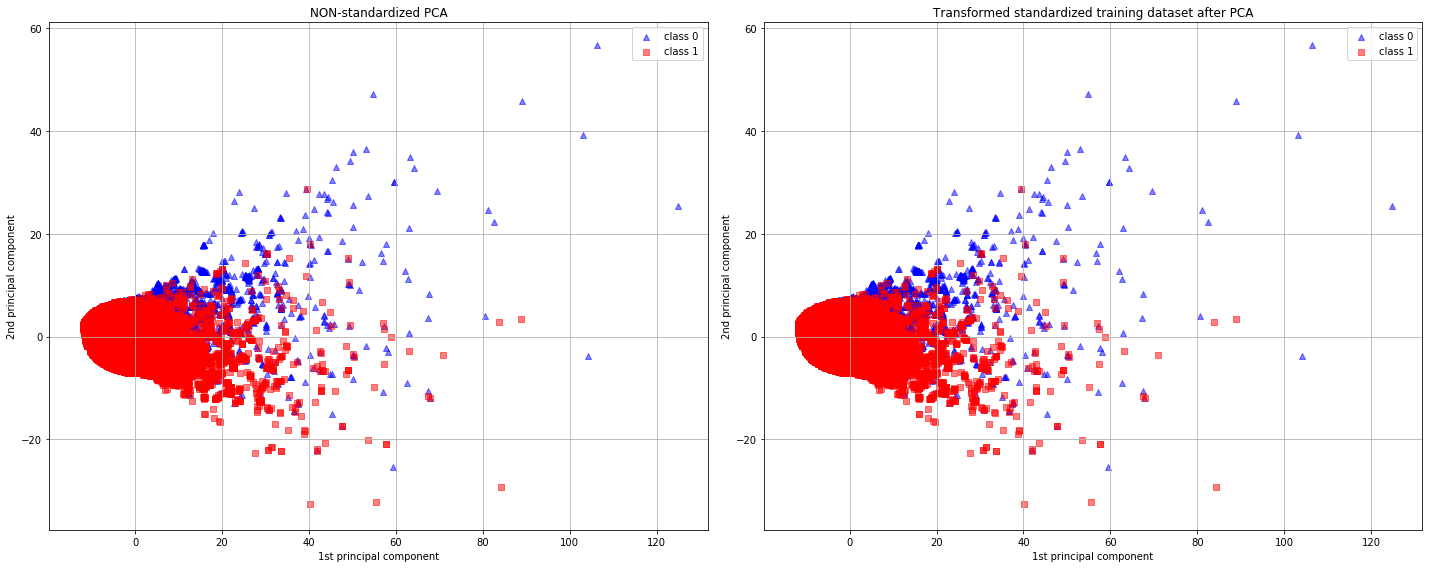

In [30]:
'''fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(ncols=2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=['blue','red'], cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))

plt.axis('tight')

plt.show()


'''
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))


for l,c,m in zip(range(0,2), ('blue', 'red'), ('^', 's')):
    ax1.scatter(X_train[target==l, 0], X_train[target==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

for l,c,m in zip(range(0,2), ('blue', 'red'), ('^', 's')):
    ax2.scatter(X_train[target==l, 0], X_train[target==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

ax1.set_title('NON-standardized PCA')    
ax2.set_title('Transformed standardized training dataset after PCA')    

for ax in (ax1, ax2):

    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()
plt.tight_layout()

plt.show()